In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Reading**

In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Fiverr/FaceDetectionSimpleMLP/template/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset']


In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

In [4]:
# loading files taken from https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-directory-possibly-including-intermediate-directories
from pathlib import Path
import shutil
import os

def dataFolder(trainImagePath, testImagePath):
  Path("./Data").mkdir(parents=True, exist_ok=True)
  Path("./Data/train").mkdir(parents=True, exist_ok=True)
  Path("./Data/test").mkdir(parents=True, exist_ok=True)

  # Creating folders for all labels (0-not wearing mask, 1-wearing mask properly, 2- wearing mask inproperly)
  for n in range(3):
    Path(f"./Data/train/{n}").mkdir(parents=True, exist_ok=True)
    Path(f"./Data/test/{n}").mkdir(parents=True, exist_ok=True)

  # Initialisng train and test path
  trainPath = './Data/train'
  testPath = './Data/test'

 # Reading the text file names and the number within the text file in train folder to match with the name of the image
  file_names = [file for file in os.listdir(trainImagePath) if file.endswith('.jpeg')]
  print(file_names)
  label_files = os.listdir('./train/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./train/labels/' + x, "r").read().strip() for x in label_files}
  # Putting the images into assigned folders for train folder
  for file in file_names:
    shutil.copy(f"{trainImagePath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

 # Reading the text file names and the number within the text file in test folder to match with the name of the image
  file_names = [file for file in os.listdir(testImagePath) if file.endswith('.jpeg')]
  label_files = os.listdir('./test/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./test/labels/' + x, "r").read().strip() for x in label_files} 
  # Putting the images into assigned folders for test folder
  for file in file_names:
    shutil.copy(f"{testImagePath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

In [5]:
# Loading the folders
dataFolder('./train/images', './test/images')

['image_0195.jpeg', 'image_0521.jpeg', 'image_1237.jpeg', 'image_0911.jpeg', 'image_0078.jpeg', 'image_2248.jpeg', 'image_0380.jpeg', 'image_1615.jpeg', 'image_1619.jpeg', 'image_0556.jpeg', 'image_0066.jpeg', 'image_1163.jpeg', 'image_0902.jpeg', 'image_0592.jpeg', 'image_1570.jpeg', 'image_1667.jpeg', 'image_0745.jpeg', 'image_1489.jpeg', 'image_0204.jpeg', 'image_1913.jpeg', 'image_1079.jpeg', 'image_1446.jpeg', 'image_0719.jpeg', 'image_2292.jpeg', 'image_1475.jpeg', 'image_1253.jpeg', 'image_1248.jpeg', 'image_0179.jpeg', 'image_0081.jpeg', 'image_0185.jpeg', 'image_2362.jpeg', 'image_1617.jpeg', 'image_1708.jpeg', 'image_1447.jpeg', 'image_1766.jpeg', 'image_1438.jpeg', 'image_2180.jpeg', 'image_1604.jpeg', 'image_0435.jpeg', 'image_2266.jpeg', 'image_0677.jpeg', 'image_0202.jpeg', 'image_0082.jpeg', 'image_0499.jpeg', 'image_0434.jpeg', 'image_0975.jpeg', 'image_0725.jpeg', 'image_0016.jpeg', 'image_1670.jpeg', 'image_1121.jpeg', 'image_0824.jpeg', 'image_1172.jpeg', 'image_2112

In [6]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
import os
import ast
import random

import torch
from torch.nn.utils.rnn import pad_sequence

### **Data Loading and HOG features Extraction**

In [33]:
def extract_hog_features(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
    
    return features, hog_image

In [34]:
# Data loader function
def load_images_from_folder(folder):
    # Initialize lists for storing images and labels
    images = []
    labels = []
    hog_images = []
    # Loop through each subfolder in the folder
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        # Loop through each image in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            # Load image
            img = cv2.imread(img_path)
            # Extract HOG features
            hog_features, hog_image = extract_hog_features(img)
            # Add image and label to the lists
            images.append(torch.tensor(hog_features))
            labels.append(int(subfolder))
            hog_images.append(hog_image)
            
    
    # Padding using pytoch pad sequence
    padded_tensors = pad_sequence(images,batch_first=True, padding_value=0)
    hog_images = np.array(hog_images, dtype=object)
    padded_numpy_array = padded_tensors.numpy()
    return padded_numpy_array , labels, hog_images

In [35]:
# Load training data
train_folder = 'Data/train'
train_images, train_labels, train_hog_images = load_images_from_folder(train_folder)

# Load testing data
test_folder = 'Data/test'
test_images, test_labels, test_hog_images = load_images_from_folder(test_folder)

<ipython-input-33-08e3e4c073ac>:5: FutureWarning:

`multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.



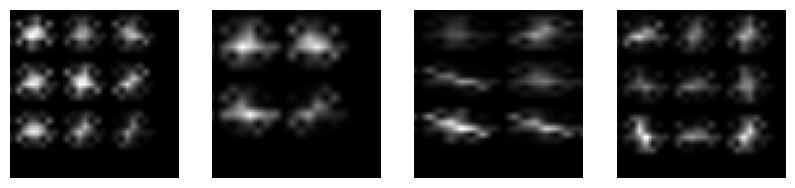

In [38]:
from skimage.transform import resize

# Define the target size for the images
target_size = (64, 64)

# Visualize the first four HOG images
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    # Resize the image to the target size
    image_resized = resize(train_hog_images[i], target_size, anti_aliasing=True)
    axs[i].imshow(image_resized, cmap='gray')
    axs[i].axis('off')
plt.show()


### **Check Class Distribution and Applying SMOTE**

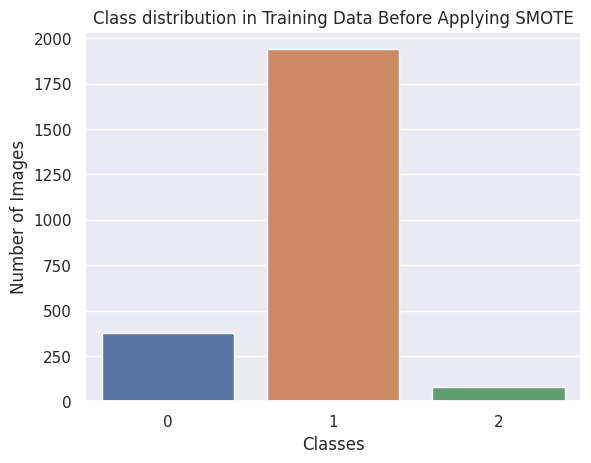

In [12]:
# craeting bar plot to check distribution in each class
import seaborn as sns
import matplotlib.pyplot as plt

zero_class = len(os.listdir('/content/Data/train/0'))
one_class = len(os.listdir('/content/Data/train/1'))
two_class = len(os.listdir('/content/Data/train/2'))



# create sample data
x = ['0', '1', '2']
y = [zero_class, one_class, two_class]

# create bar plot using Seaborn
sns.set(style='darkgrid')
sns.barplot(x=x, y=y)

# set plot title and axis labels
plt.title('Class distribution in Training Data Before Applying SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

# display plot
plt.show()


In [13]:
print(test_images.shape)
print(train_images.shape)
print(len(train_labels))
print(len(test_labels))
# print(test_images_reshaped.shape)

(458, 35496)
(2394, 56088)
2394
458


In [14]:
import numpy as np
from imblearn.over_sampling import SMOTE

# Create SMOTE object
sm = SMOTE(random_state=42)

# Convert train_labels to numpy array and reshape to match the number of rows in train_images
train_labels_np = np.array(train_labels)
train_labels_reshaped = train_labels_np.reshape(-1, 1)

# Apply SMOTE to train_images and train_labels
train_images_resampled, train_labels_resampled = sm.fit_resample(train_images, train_labels_reshaped)

# Reshape train_labels back to 1D array
train_labels_resampled = train_labels_resampled.ravel()

# Check the new class distribution
print('Class Distribution after SMOTE:', np.bincount(train_labels_resampled))

# Now train_images_resampled and train_labels_resampled can be used for training the classifier


Class Distribution after SMOTE: [1940 1940 1940]


In [17]:
print(np.bincount(train_labels_resampled))

[1940 1940 1940]


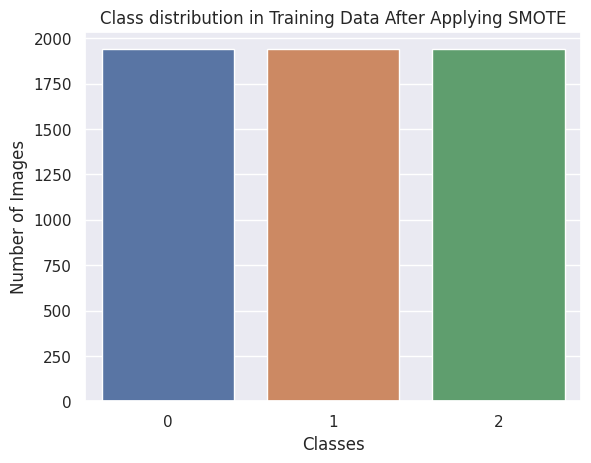

In [18]:
# craeting bar plot to check distribution in each class
import seaborn as sns
import matplotlib.pyplot as plt

# create sample data
x = ['0', '1', '2']
y = np.bincount(train_labels_resampled)

# create bar plot using Seaborn
sns.set(style='darkgrid')
sns.barplot(x=x, y=y)

# set plot title and axis labels
plt.title('Class distribution in Training Data After Applying SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

# display plot
plt.show()


In [19]:
print(train_images_resampled.shape)
print(train_labels_resampled.shape)

(5820, 56088)
(5820,)


### **MLP Classifier**

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# Create MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.0001,
                               solver='adam', verbose=10, tol=0.0001, random_state=1)

# Train MLP classifier
mlp_classifier.fit(train_images, train_labels)

# Test MLP classifier

# assume train_images is already loaded with shape (2394, 56088)
# assume test_images is already loaded with shape (458, 35496)

# calculate the total number of features
num_features = train_images.shape[1]

# reshape the test set to match the number of features in the training set
test_images_reshaped = np.zeros((test_images.shape[0], num_features))
test_images_reshaped[:, :test_images.shape[1]] = test_images

# now test_images_reshaped has shape (458, 56088), which is the same as train_images
mlp_score = mlp_classifier.score(test_images_reshaped, test_labels)
print('MLP Classifier Accuracy:', mlp_score)

Iteration 1, loss = 0.98113188
Iteration 2, loss = 0.73060127
Iteration 3, loss = 0.63138381
Iteration 4, loss = 0.58489062
Iteration 5, loss = 0.54699308
Iteration 6, loss = 0.52141077
Iteration 7, loss = 0.50390547
Iteration 8, loss = 0.48937269
Iteration 9, loss = 0.47506854
Iteration 10, loss = 0.46591983
Iteration 11, loss = 0.45475644
Iteration 12, loss = 0.44618905
Iteration 13, loss = 0.43733275
Iteration 14, loss = 0.42991757
Iteration 15, loss = 0.42266330
Iteration 16, loss = 0.41612314
Iteration 17, loss = 0.40845490
Iteration 18, loss = 0.40183979
Iteration 19, loss = 0.39548131
Iteration 20, loss = 0.38982789
Iteration 21, loss = 0.38422594
Iteration 22, loss = 0.37829293
Iteration 23, loss = 0.37391752
Iteration 24, loss = 0.37031450
Iteration 25, loss = 0.36599113
Iteration 26, loss = 0.36128317
Iteration 27, loss = 0.35636486
Iteration 28, loss = 0.35221195
Iteration 29, loss = 0.34994772
Iteration 30, loss = 0.34517695
Iteration 31, loss = 0.34124679
Iteration 32, los

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Classifier Accuracy: 0.7860262008733624


**Confusion Matrix**

In [21]:
from sklearn.metrics import confusion_matrix

# predict the labels of the test set using the trained SVM classifier
test_pred = mlp_classifier.predict(test_images_reshaped)
# calculate the confusion matrix
conf_mat = confusion_matrix(test_labels, test_pred)
print('Confusion Matrix:\n', conf_mat)

Confusion Matrix:
 [[ 13  37   1]
 [ 35 347   6]
 [  7  12   0]]


**TP, TN, FP, and FN Values for each Class**

In [25]:
# Calculate the total number of true positives, true negatives, false positives, and false negatives for each class
for i in range(len(conf_mat)):
    tp = conf_mat[i,i]
    tn = np.sum(conf_mat) - np.sum(conf_mat[i,:]) - np.sum(conf_mat[:,i]) + tp
    fp = np.sum(conf_mat[:,i]) - tp
    fn = np.sum(conf_mat[i,:]) - tp
    print("Class {}: TP = {}, TN = {}, FP = {}, FN = {}".format(i, tp, tn, fp, fn))

Class 0: TP = 13, TN = 365, FP = 42, FN = 38
Class 1: TP = 347, TN = 21, FP = 49, FN = 41
Class 2: TP = 0, TN = 432, FP = 7, FN = 19


### **SVM Classifier**

In [22]:
# Create SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale')

# Train SVM classifier
svm_classifier.fit(train_images, train_labels)

# Test SVM classifier
# assume train_images is already loaded with shape (2394, 56088)
# assume test_images is already loaded with shape (458, 35496)

# calculate the total number of features
num_features = train_images.shape[1]

# reshape the test set to match the number of features in the training set
test_images_reshaped = np.zeros((test_images.shape[0], num_features))
test_images_reshaped[:, :test_images.shape[1]] = test_images

svm_score = svm_classifier.score(test_images_reshaped, test_labels)
print('SVM Classifier Accuracy:', svm_score)

SVM Classifier Accuracy: 0.8471615720524017


**Confusion Matrix**

In [23]:
from sklearn.metrics import confusion_matrix

# predict the labels of the test set using the trained SVM classifier
predicted_labels = svm_classifier.predict(test_images_reshaped)

# calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)


Confusion Matrix:
[[  0  51   0]
 [  0 388   0]
 [  0  19   0]]


**TP, TN, FP, and FN Values for each Class**

In [24]:
# Calculate the total number of true positives, true negatives, false positives, and false negatives for each class
for i in range(len(conf_matrix)):
    tp = conf_matrix[i,i]
    tn = np.sum(conf_matrix) - np.sum(conf_matrix[i,:]) - np.sum(conf_matrix[:,i]) + tp
    fp = np.sum(conf_matrix[:,i]) - tp
    fn = np.sum(conf_matrix [i,:]) - tp
    print("Class {}: TP = {}, TN = {}, FP = {}, FN = {}".format(i, tp, tn, fp, fn))

Class 0: TP = 0, TN = 407, FP = 0, FN = 51
Class 1: TP = 388, TN = 0, FP = 70, FN = 0
Class 2: TP = 0, TN = 439, FP = 0, FN = 19


### **Comparing both Algorithms Acuracy**

In [26]:
import plotly.graph_objects as go
metrics=['MLP Classifier', 'SVM']
score = [mlp_score.round(2), svm_score.round(2)]

fig = go.Figure([go.Bar(x=metrics, y=score, text=score, textposition='inside', width=0.3)])
fig.update_layout(title='Accuracy Score Comparison between MLP and SVM Classifier', xaxis_title='Metrics', yaxis_title='Score')
fig.show()